## Семинар 7: "Методы оптимизации"

ФИО: Валиахметов Булат Ильдарович

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

День добрый!
То есть нужно все изменения параметров усреднять, а затем экспоненциально сглаживать? Вроде бы это не совсем ладится с идеей отсылки к методу Ньютона

In [14]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.zero_()
  
    def step(self, F):
        loss = F()
        loss.backward()  

        
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad


class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v
                

class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.gamma = gamma
    
    def step(self, F):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v
        super().step(F)
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param += v
                
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                
                param -= v
     
    
class Adagrad(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.eps = 1e-9
        self.grad_sums = [torch.zeros_like(param) for param in self.parameters]
        
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for grad_sum, param in zip(self.grad_sums, self.parameters):
                grad_sum += param.grad ** 2
                param -= self.learning_rate / torch.sqrt(grad_sum + self.eps) * param.grad
    
    
class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 1e-8
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad
                

class Adadelta(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.95):
        super().__init__(parameters)
        self.Eg = [torch.zeros_like(param) for param in self.parameters]
        self.Edp = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 1e-3
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for g, dp, param in zip(self.Eg, self.Edp, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                q = torch.sqrt((dp + self.eps) / (g + self.eps))
                print(q.shape)
                new_dp = q * param.grad
                param -= new_dp
                dp.copy_(self.gamma * dp + (1 - self.gamma) * new_dp ** 2)


class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(parameters)
        self.M = [torch.zeros_like(param) for param in self.parameters]
        self.V = [torch.zeros_like(param) for param in self.parameters]
        self.eps = eps
        self.beta1 = beta1
        self.beta2 = beta2
        self.learning_rate = learning_rate
        self.time_step = 0
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            self.time_step += 1
            for m, v, param in zip(self.M, self.V, self.parameters):
                m.copy_(self.beta1 * m + (1 - self.beta1) * param.grad)
                v.copy_(self.beta2 * v + (1 - self.beta2) * param.grad ** 2)
                
                m_true = m / (1 - self.beta1 ** self.time_step)
                v_true = v / (1 - self.beta2 ** self.time_step)
                #print(m_true, v_true)
                param -= self.learning_rate * m_true / (torch.sqrt(v_true) + self.eps)

In [15]:
def F0(x):
    x, y = x[:, 0], x[:, 1]
    return torch.sin(x) * x**2 * y + torch.cos(y**2) * y**2

def test_method(F, optim, learning_rate, x_0, steps=20, print_pts=False):
    if print_pts:
        print(optim.__name__)

    x = torch.tensor(x_0, requires_grad=True)
    optim = optim([x], learning_rate=learning_rate)

    points = []

    for i in range(steps):
        p_z = F(x).item()
        p_x, p_y = x.detach().numpy().flatten()        
        if print_pts:
            print(i, p_z, p_x, p_y)
        points.append((p_x, p_y, p_z))

        optim.step(lambda: F(x))
        optim.zero_grad()

    return points

In [16]:
def plot_optims(optim_path, names):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(121, projection='3d')
    colors = ["red", "blue", "yellow", "pink", "green", "gray", "black"]

    # Plot a basic wireframe.
    #ax.plot_wireframe(space, space, Z)
    for color, path in zip(colors, optim_path):
        points = np.array(path)
        points += np.random.rand(3) * 0.04
        plt.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=3)

    plt.subplot(122)
    for color, path, name in zip(colors, optim_path, names):
        points = np.array(path)        
        plt.plot(points[:, 0], points[:, 1], color=color, linewidth=3, label=name)
    plt.legend(fontsize=10)
    plt.show()

torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])


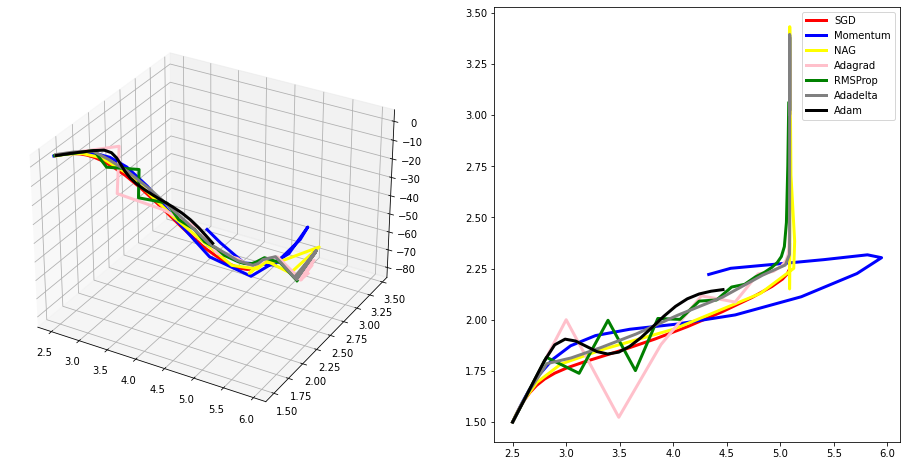

In [17]:
def test_func_by_all(func, x_0, steps=20, print_pts=False):
    optimizers = [SGD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam]
    l_rates = [0.01, 0.005, 0.01, 0.5, 0.1, None, 0.1]
    optim_path = []
    names = [optim.__name__ for optim in optimizers]
    for opt, l_r in zip(optimizers, l_rates):
        optim_path.append(test_method(func, opt, l_r, x_0, steps, print_pts))
    plot_optims(optim_path, names)
    

x_0 = np.array([2.5, 1.5]).reshape(1, -1)
test_func_by_all(F0, x_0)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

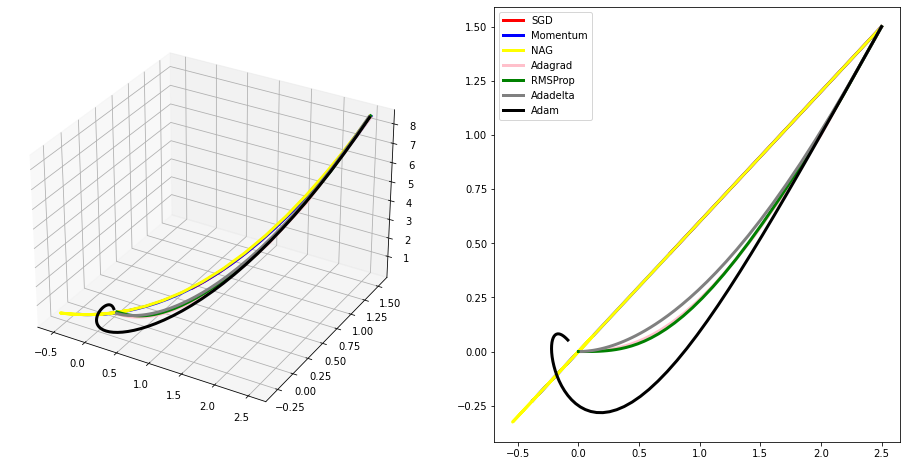

In [6]:
f = lambda X: X[:, 0]**2+X[:, 1]**2
# df = lambda X: np.array([2*X[0], 2*X[1]])

x_0 = np.array([2.5, 1.5]).reshape(1, -1)
test_func_by_all(f, x_0, steps=60)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

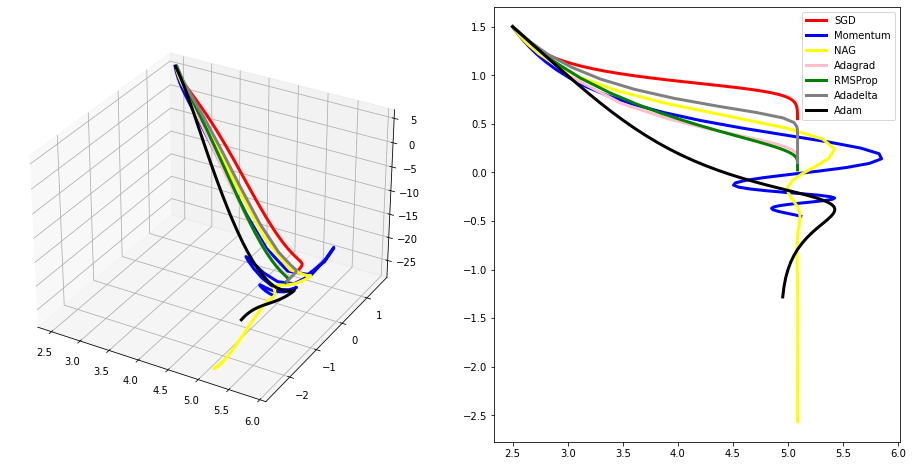

In [7]:
f = lambda X: X[:, 0]**2 * torch.sin(X[:, 0]) + X[:, 1]**2 * torch.sin(X[:, 1])

x_0 = np.array([2.5, 1.5]).reshape(1, -1)
test_func_by_all(f, x_0, steps=50)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

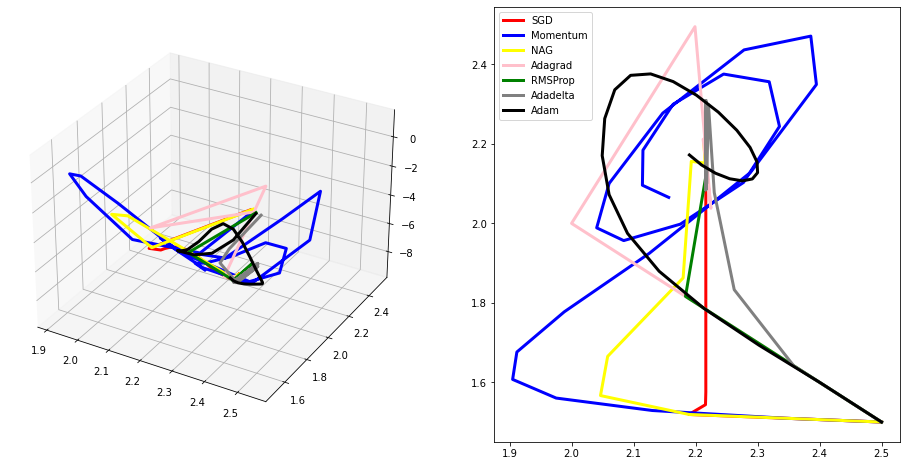

In [8]:
f = lambda X: X[:, 0]**2 * torch.sin(X[:, 0]**2) + X[:, 1]**2 * torch.sin(X[:, 1]**2)

x_0 = np.array([2.5, 1.5]).reshape(1, -1)
test_func_by_all(f, x_0, steps=25)

* Более сложные методы сходятся более "плавно".
* Momentum сильно болтает.
* Adam на некоторых функциях может сходиться дольше остальных.

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [9]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.zero_()
  
    def step(self):
        pass 

        
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
    
    def step(self):
        super().step()
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad


class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.gamma = gamma
    
    def step(self):
        super().step()
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v
                

class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.gamma = gamma
    
    def step(self):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v
        super().step()
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param += v
                
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                
                param -= v
     
    
class Adagrad(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.eps = 1e-9
        self.grad_sums = [torch.zeros_like(param) for param in self.parameters]
        
    def step(self):
        super().step()
        with torch.no_grad():
            for grad_sum, param in zip(self.grad_sums, self.parameters):
                grad_sum += param.grad ** 2
                param -= self.learning_rate / torch.sqrt(grad_sum + self.eps) * param.grad
    
    
class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 1e-8
        self.gamma = gamma
    
    def step(self):
        super().step()
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad
                

class Adadelta(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.95):
        super().__init__(parameters)
        self.Eg = [torch.zeros_like(param) for param in self.parameters]
        self.Edp = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 1e-3
        self.gamma = gamma
    
    def step(self):
        super().step()
        with torch.no_grad():
            for g, dp, param in zip(self.Eg, self.Edp, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                new_dp = torch.sqrt((dp + self.eps) / (g + self.eps)) * param.grad
                param -= new_dp
                dp.copy_(self.gamma * dp + (1 - self.gamma) * new_dp ** 2)
    

class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(parameters)
        self.M = [torch.zeros_like(param) for param in self.parameters]
        self.V = [torch.zeros_like(param) for param in self.parameters]
        self.eps = eps
        self.beta1 = beta1
        self.beta2 = beta2
        self.learning_rate = learning_rate
        self.time_step = 0
    
    def step(self):
        super().step()
        with torch.no_grad():
            self.time_step += 1
            for m, v, param in zip(self.M, self.V, self.parameters):
                m.copy_(self.beta1 * m + (1 - self.beta1) * param.grad)
                v.copy_(self.beta2 * v + (1 - self.beta2) * param.grad ** 2)
                
                m_true = m / (1 - self.beta1 ** self.time_step)
                v_true = v / (1 - self.beta2 ** self.time_step)
                #print(m_true, v_true)
                param -= self.learning_rate * m_true / (torch.sqrt(v_true) + self.eps)

In [10]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

In [30]:
# %load train_utils.py
import numpy as np
#from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
from IPython.display import clear_output

def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            loss_batch.backward()
            optimizer.step()
        prediction = prediction.max(1)[1]
        accuracies.append((prediction==y).cpu().float().numpy().mean())
    return losses, accuracies


def train(network, train_loader, test_loader,
          epochs, learning_rate, optimizer, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
    loss = nn.NLLLoss()
    optimizer = optim(list(network.parameters()), learning_rate=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses, accuracies = _epoch(network,
                                        loss,
                                        test_loader,
                                        False,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [31]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [32]:
optimizers = iter([SGD, Adagrad,  Adadelta, Adam])
l_rates = iter([0.01, 0.5, None, 0.1])

Epoch 9... (Train/Test) NLL: 0.070/0.085	Accuracy: 0.981/0.974


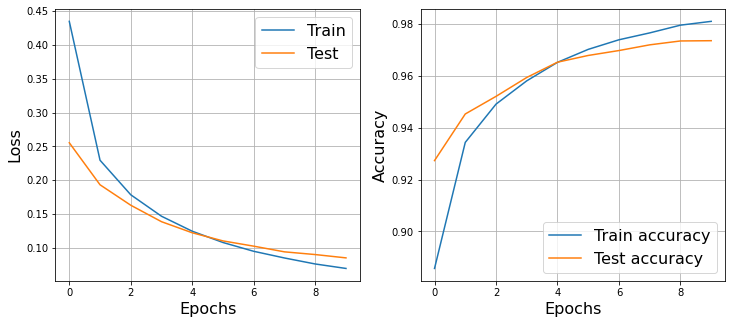

([0.4348212972164154,
  0.22958731386164824,
  0.17853307298670212,
  0.14681711689531804,
  0.12467492524037758,
  0.10800416901359955,
  0.09501558643057942,
  0.08514346477637688,
  0.076284833791852,
  0.0696836777843535],
 [0.2554242817072061,
  0.19331368217810083,
  0.16308577887761516,
  0.13875955547066257,
  0.12238606339850175,
  0.11037302995249391,
  0.10259696951034827,
  0.09421382394556801,
  0.09020358625466164,
  0.08529437936473483],
 [0.8857333,
  0.9343333,
  0.9490833,
  0.95806664,
  0.9652,
  0.9702,
  0.9739,
  0.97655,
  0.9795333,
  0.981],
 [0.9273163,
  0.9452875,
  0.9520767,
  0.959365,
  0.9652556,
  0.96785146,
  0.9697484,
  0.97194487,
  0.9734425,
  0.97354233])

In [33]:
layers = [nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10)]
network = nn.Sequential(*layers)
optim, l_r = SGD, 0.01

layers = [nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10), nn.LogSoftmax(dim=1)]
network = nn.Sequential(*layers)
train(network, train_loader, test_loader, epochs=10, learning_rate=l_r, optimizer=optim, ravel_init=True)

Epoch 9... (Train/Test) NLL: 0.033/0.066	Accuracy: 0.992/0.980


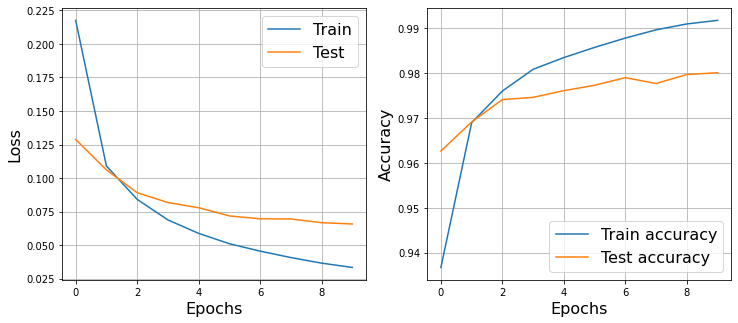

([0.21756988840003808,
  0.10902353397409122,
  0.08412987723300855,
  0.0687749716822058,
  0.05875452599984904,
  0.05103358552331726,
  0.04549205991687874,
  0.040715497634373606,
  0.03654543146553139,
  0.033343573572238286],
 [0.12875679929773456,
  0.10610517286383116,
  0.08907746322179279,
  0.08174335719800344,
  0.0778765473589182,
  0.07176837868342836,
  0.06959656251151079,
  0.06949219657718159,
  0.06672890036822127,
  0.06574122056799432],
 [0.9367,
  0.96898335,
  0.97605,
  0.9809,
  0.9835167,
  0.98578334,
  0.98786664,
  0.9897,
  0.9910167,
  0.99181664],
 [0.9626597,
  0.96914935,
  0.97414136,
  0.97464055,
  0.9761382,
  0.9773363,
  0.9790335,
  0.97773564,
  0.97973245,
  0.9801318])

In [34]:
layers = [nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10)]
network = nn.Sequential(*layers)
optim, l_r = Adagrad, 0.01

layers = [nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10), nn.LogSoftmax(dim=1)]
network = nn.Sequential(*layers)
train(network, train_loader, test_loader, epochs=10, learning_rate=l_r, optimizer=optim, ravel_init=True)

Epoch 9... (Train/Test) NLL: 0.178/0.310	Accuracy: 0.963/0.951


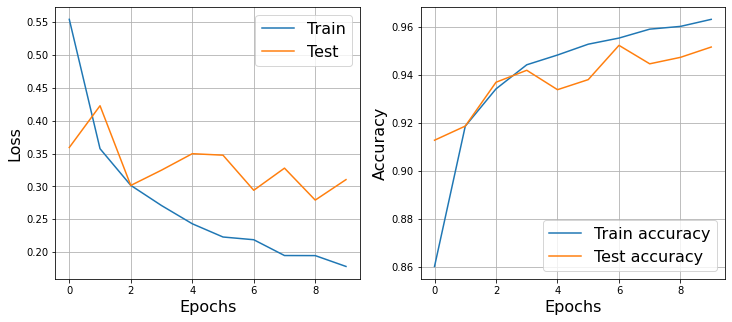

([0.5542863413664202,
  0.3573891454424088,
  0.30162344083863624,
  0.2709172131306957,
  0.2431849466913302,
  0.22301871913838453,
  0.21887017554057722,
  0.1948178392058646,
  0.1947151512046969,
  0.17820900994047378],
 [0.35923386523172784,
  0.4228142888639301,
  0.3014817545755793,
  0.3247758682382802,
  0.3498211855235429,
  0.3475543875449944,
  0.2941267543615126,
  0.32783746474320974,
  0.27919389838114994,
  0.31035775369640956],
 [0.86003333,
  0.9185,
  0.93403333,
  0.94408333,
  0.94815,
  0.95266664,
  0.95521665,
  0.95893335,
  0.9600833,
  0.9630167],
 [0.9126398,
  0.91853034,
  0.93680114,
  0.94179314,
  0.93370605,
  0.93789935,
  0.9521765,
  0.9444888,
  0.9471845,
  0.95147765])

In [35]:
layers = [nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10)]
network = nn.Sequential(*layers)
optim, l_r = Adadelta, None

layers = [nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10), nn.LogSoftmax(dim=1)]
network = nn.Sequential(*layers)
train(network, train_loader, test_loader, epochs=10, learning_rate=l_r, optimizer=optim, ravel_init=True)

Epoch 9... (Train/Test) NLL: 0.023/0.094	Accuracy: 0.992/0.979


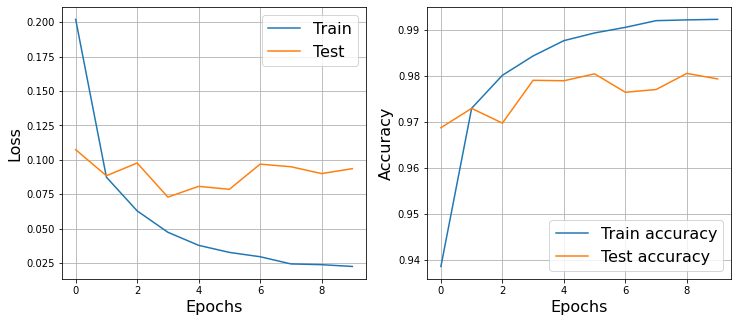

([0.20200035381391646,
  0.08740396949866165,
  0.06292842993938054,
  0.047394918502712,
  0.03790603488523048,
  0.032776406346594254,
  0.029629215770573744,
  0.024420659369234637,
  0.023859257085987823,
  0.022575946845248836],
 [0.10737170274265277,
  0.08842556009005112,
  0.0976971743339018,
  0.07292110216357528,
  0.08073234116354884,
  0.07858818006121573,
  0.09685911200300418,
  0.094982218032716,
  0.09001218937763146,
  0.09357124494629616],
 [0.93866664,
  0.9729667,
  0.98011667,
  0.98431665,
  0.98763335,
  0.9893,
  0.99051666,
  0.99196666,
  0.9921333,
  0.99225],
 [0.96875,
  0.9729433,
  0.9697484,
  0.9790335,
  0.9789337,
  0.9804313,
  0.9764377,
  0.9770367,
  0.98053116,
  0.97933304])

In [40]:
layers = [nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10)]
network = nn.Sequential(*layers)
optim, l_r = Adam, 0.001

layers = [nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10), nn.LogSoftmax(dim=1)]
network = nn.Sequential(*layers)
train(network, train_loader, test_loader, epochs=10, learning_rate=l_r, optimizer=optim, ravel_init=True)

Сравнивая SGD, Adagrad, Adadelta и Adam на полносвязной сети, можно сделать следующие **выводы**:
* все методы на трейне ведут себя плавно, но SGD и Adagrad более гладкие на тесте, без резких скачков по эпохам.
* Adam и Adagrad на первых эпохах дают заметно лучшее приближение, чем SGD и Adadelta (97-98 против 93-95)
* методы после 3-4 эпох начинают переобучать сеть, наверное, потому что она очень простая

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [52]:
channels = 1
class ConvClassifier2(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 8, 3, padding=1),
            nn.ReLU(), 
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(32 * image_size//2 * image_size//2, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.037/0.045	Accuracy: 0.988/0.983


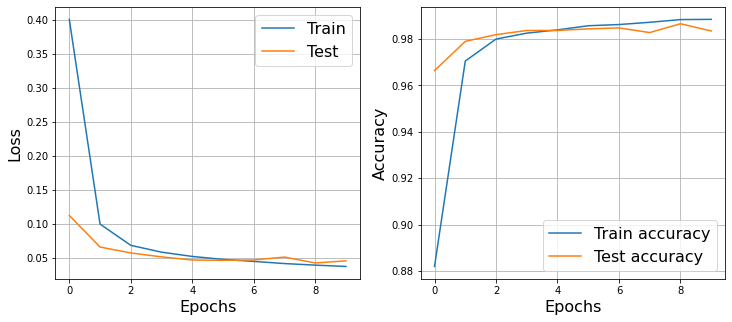

([0.40106324840784074,
  0.09952985037242373,
  0.06815470266162107,
  0.05810783975139881,
  0.05183506682530666,
  0.04745327219373236,
  0.04451321408015986,
  0.04131425726794017,
  0.038995702080009506,
  0.03707165422877297],
 [0.11220366652078997,
  0.06566676153866842,
  0.05696718752370796,
  0.05118830328116925,
  0.0465655628849898,
  0.046077612910781225,
  0.046652855810719714,
  0.050850656055756054,
  0.04218966059629231,
  0.04530551120454368],
 [0.88203335,
  0.9704667,
  0.9799333,
  0.9824833,
  0.9838833,
  0.9856667,
  0.98618335,
  0.98715,
  0.98831666,
  0.9884167],
 [0.96635383,
  0.9789337,
  0.98182905,
  0.9836262,
  0.9836262,
  0.98432505,
  0.98472446,
  0.98272765,
  0.98652154,
  0.9834265])

In [54]:
network = ConvClassifier2(image_size=28)
optim, l_r = SGD, 0.01
train(network, train_loader, test_loader, epochs=10, learning_rate=l_r, optimizer=optim, ravel_init=False)

Epoch 9... (Train/Test) NLL: 0.074/0.072	Accuracy: 0.977/0.978


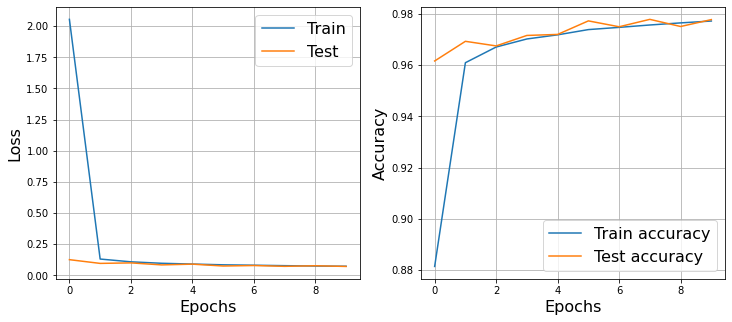

([2.0544761662729085,
  0.13139078890172143,
  0.10909279536195099,
  0.09740411480258529,
  0.09114781396494558,
  0.08507894797573487,
  0.08190136402156203,
  0.07824014058525984,
  0.0752277297250616,
  0.07373826679520619],
 [0.12640683468097982,
  0.0964915192270943,
  0.10059754426900547,
  0.08443305054649758,
  0.09045966240776757,
  0.07553550443714693,
  0.0793782490128562,
  0.07293751071703385,
  0.07758992578954801,
  0.07201543415802868],
 [0.88133335,
  0.96098334,
  0.96711665,
  0.97026664,
  0.97188336,
  0.97393334,
  0.9748,
  0.97573334,
  0.97655,
  0.97728336],
 [0.96166134,
  0.969349,
  0.96755195,
  0.97164536,
  0.9720447,
  0.9773363,
  0.97503996,
  0.9779353,
  0.9751398,
  0.9778355])

In [55]:
network = ConvClassifier2(image_size=28)
optim, l_r = Adagrad, 0.1
train(network, train_loader, test_loader, epochs=10, learning_rate=l_r, optimizer=optim, ravel_init=False)

Epoch 9... (Train/Test) NLL: 56.447/32.641	Accuracy: 0.100/0.101


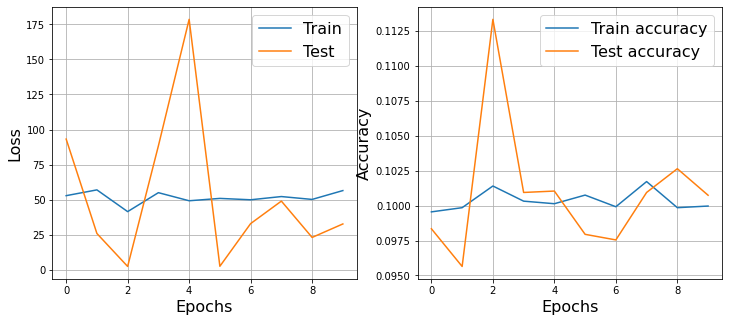

([52.81544336433411,
  56.945231270726524,
  41.437062159729,
  54.953397849146526,
  49.18277187245687,
  50.863301417922976,
  49.87963319714864,
  52.18193218688965,
  50.13861742706299,
  56.44712221679688],
 [93.18510224948676,
  25.835549314943748,
  2.3214453531149477,
  88.34889525879686,
  178.60136630512275,
  2.4473555545075634,
  32.88054462591299,
  48.94055173343744,
  23.0197475786788,
  32.64089510006646],
 [0.09955,
  0.09985,
  0.1014,
  0.100316666,
  0.10013333,
  0.10075,
  0.09991667,
  0.10171667,
  0.09985,
  0.09996667],
 [0.09834265,
  0.09564696,
  0.11331869,
  0.1009385,
  0.10103834,
  0.09794329,
  0.09754393,
  0.1009385,
  0.102635786,
  0.100738816])

In [56]:
network = ConvClassifier2(image_size=28)
optim, l_r = Adadelta, None
train(network, train_loader, test_loader, epochs=10, learning_rate=l_r, optimizer=optim, ravel_init=False)

In [58]:
# сделаем поправку eps: 1e-3 -> 1e-5
# иначе сеть не учится вовсе
class Adadelta(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.95):
        super().__init__(parameters)
        self.Eg = [torch.zeros_like(param) for param in self.parameters]
        self.Edp = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 1e-5
        self.gamma = gamma
    
    def step(self):
        super().step()
        with torch.no_grad():
            for g, dp, param in zip(self.Eg, self.Edp, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                new_dp = torch.sqrt((dp + self.eps) / (g + self.eps)) * param.grad
                param -= new_dp
                dp.copy_(self.gamma * dp + (1 - self.gamma) * new_dp ** 2)

Epoch 9... (Train/Test) NLL: 0.051/0.070	Accuracy: 0.987/0.982


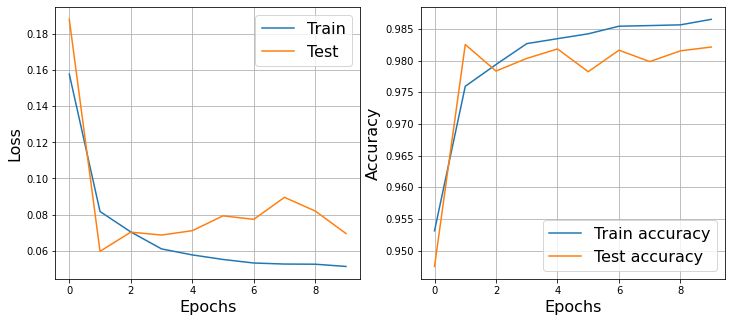

([0.15772019512204763,
  0.08173455637445441,
  0.07044295309394753,
  0.061049602666592304,
  0.05773272222789868,
  0.055210588543517465,
  0.05325043311104,
  0.052672951964534635,
  0.052585593699804666,
  0.05134951423247552],
 [0.18800929544297174,
  0.059707099840988015,
  0.07032688509748848,
  0.06870702138724573,
  0.07112682354907596,
  0.07933460242209246,
  0.07739645755831764,
  0.08956531639833896,
  0.08199831257784557,
  0.06956604274156748],
 [0.95311666,
  0.9759333,
  0.97936666,
  0.9826667,
  0.98345,
  0.9842167,
  0.98541665,
  0.98551667,
  0.9856333,
  0.9865],
 [0.947484,
  0.982528,
  0.97833467,
  0.9803315,
  0.98182905,
  0.9782348,
  0.9816294,
  0.9798323,
  0.98152953,
  0.9821286])

In [59]:
network = ConvClassifier2(image_size=28)
optim, l_r = Adadelta, None
train(network, train_loader, test_loader, epochs=10, learning_rate=l_r, optimizer=optim, ravel_init=False)

Epoch 9... (Train/Test) NLL: 0.017/0.056	Accuracy: 0.994/0.985


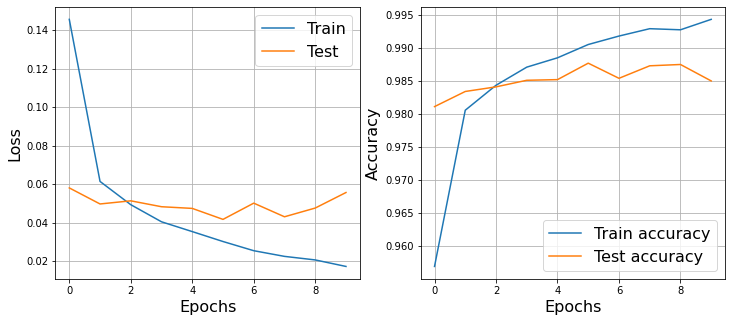

([0.1456818477434727,
  0.06144765448911736,
  0.049362495108150564,
  0.04047014330031816,
  0.03537681577104377,
  0.03022190516801493,
  0.025447766308361316,
  0.02249850170472734,
  0.020652360662438453,
  0.01726578194117216],
 [0.058082578169292035,
  0.04973726911386981,
  0.051368863207471076,
  0.04830228894712409,
  0.04743234187684395,
  0.04172762286172958,
  0.05016507175269027,
  0.04307914588301641,
  0.04761724867027418,
  0.055690531676961336],
 [0.9568833,
  0.9805833,
  0.98436666,
  0.9871167,
  0.9885333,
  0.99055,
  0.9918333,
  0.99295,
  0.9927833,
  0.99436665],
 [0.9811302,
  0.9834265,
  0.9841254,
  0.9851238,
  0.98522365,
  0.98771966,
  0.9854233,
  0.9873203,
  0.98752,
  0.985024])

In [60]:
network = ConvClassifier2(image_size=28)
optim, l_r = Adam, 0.001
train(network, train_loader, test_loader, epochs=10, learning_rate=l_r, optimizer=optim, ravel_init=False)

Сравнивая SGD, Adagrad, Adadelta и Adam на свёрточной сети, можно сделать следующие **выводы**:
* все методы учатся примерно одинаковыми темпами - скачок между 0-1 эпохами, потом медленный рост
* Adagrad очень бытсро замедляет рост, так как у сети очень много параметров и все они должны учиться постепенно, не сразу $\Rightarrow$ быстро копится сумма квадратов градиентов и метод затухает
* Adadelta снова имеет скачки на тесте
* Adam и SGD, что интересно, показывают заметно лучший результат на первых эпохах по сравнению с Adagrad и Adadelta

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: